# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

### Загрузка данных

Здесь будем собирать все импорты

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score

Откроем датасет

In [2]:
data = pd.read_csv('/datasets/autos.csv')

In [3]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

В нашем распоряжении таблица на 16 столбцов и 354368 строк. Бросим первый взгляд на то, как распределяются числовые признаки.

array([[<AxesSubplot:title={'center':'Price'}>,
        <AxesSubplot:title={'center':'RegistrationYear'}>,
        <AxesSubplot:title={'center':'Power'}>],
       [<AxesSubplot:title={'center':'Kilometer'}>,
        <AxesSubplot:title={'center':'RegistrationMonth'}>,
        <AxesSubplot:title={'center':'NumberOfPictures'}>],
       [<AxesSubplot:title={'center':'PostalCode'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

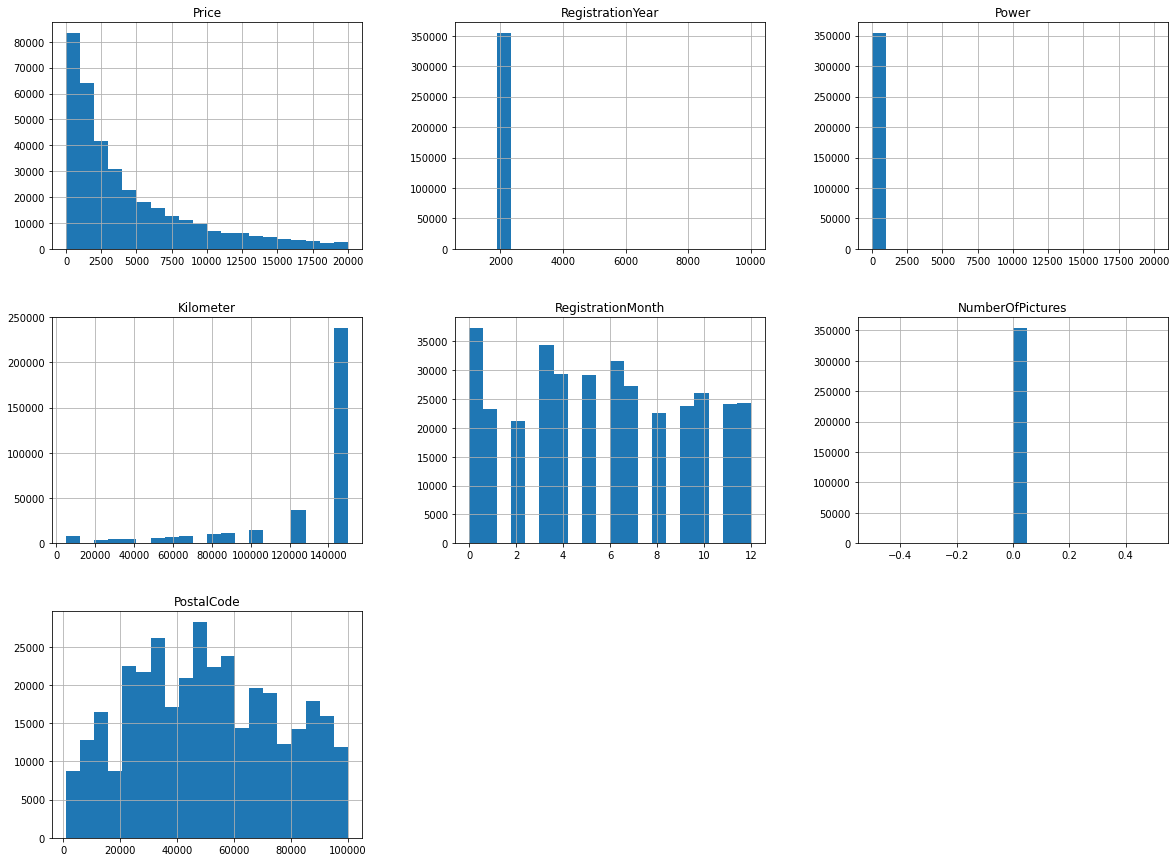

In [5]:
data.hist(bins=20, figsize=(20,15))

Проверим таблицу на повторы и удалим их.

In [6]:
data.duplicated().sum()

4

In [7]:
data = data.drop_duplicates()

Также посмотрим на количество пропусков в столбцах. Решать, что с ними делать будем позже для каждого отдельного столбца.

In [8]:
data.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

### Дата скачивания анкеты из базы

Пока непонятно, для чего нужен этот столбец. Пропусков в нем нет. Другие изменения пока не будем делать.

In [9]:
data['DateCrawled'].isna().sum()

0

In [10]:
data['DateCrawled']

0         2016-03-24 11:52:17
1         2016-03-24 10:58:45
2         2016-03-14 12:52:21
3         2016-03-17 16:54:04
4         2016-03-31 17:25:20
                 ...         
354364    2016-03-21 09:50:58
354365    2016-03-14 17:48:27
354366    2016-03-05 19:56:21
354367    2016-03-19 18:57:12
354368    2016-03-20 19:41:08
Name: DateCrawled, Length: 354365, dtype: object

In [11]:
data['DateCrawled'] = pd.to_datetime(data['DateCrawled'], format='%Y-%m-%d %H:%M')
data['DateCrawled'] = data['DateCrawled'].dt.year

In [12]:
data['DateCrawled'].unique()

array([2016])

### Цена (евро)

Цена машины в евро. Пропуски также отсутствуют. Но в то же время есть как нулевые и очень низкие значения, так и очень высокие.

In [13]:
data['Price'].isna().sum()

0

In [14]:
data['Price'].describe()

count    354365.000000
mean       4416.679830
std        4514.176349
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64

На графиках видно, что дорогих машин в нашей таблице достаточно много, цены на них стоят плотно, т.е. эти значения в большинстве своем не похожи на выбросы или какие-то ошибочные значения.

<AxesSubplot:>

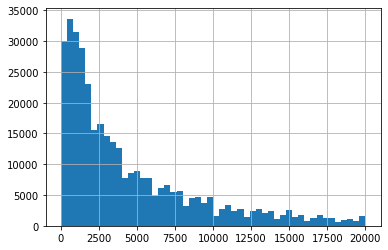

In [15]:
data['Price'].hist(bins=50)

<AxesSubplot:xlabel='Price'>

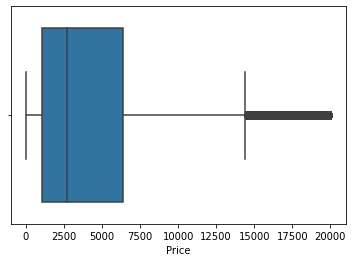

In [16]:
sns.boxplot(x=data['Price'])

<AxesSubplot:>

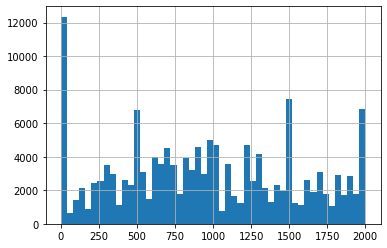

In [17]:
data['Price'].hist(bins=50, range=(0, 2000))

<AxesSubplot:>

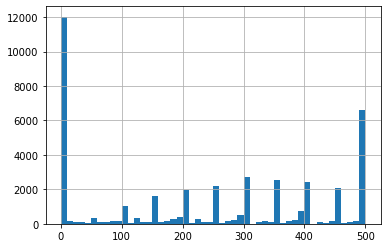

In [18]:
data['Price'].hist(bins=50, range=(0, 500))

Сложнее ситуация с низкими значениями цен. Мы видим большое количество нулевых значений. Также как правило продавцы ставят на свои автомобили круглые цены. И таких лотов, начиная со 100 евро, достаточно много. Попробуем удалить совсем низкие (меньше 99 евро) и нулевые значения.

In [19]:
data = data.query('Price > 99')

In [20]:
data['Price'].describe()

count    341051.000000
mean       4588.887026
std        4514.862284
min         100.000000
25%        1200.000000
50%        2900.000000
75%        6500.000000
max       20000.000000
Name: Price, dtype: float64

### Тип кузова

В этом столбце очень много пропусков, но все их можно заменить на 'other'.

In [21]:
data['VehicleType'].isna().sum()

32612

In [22]:
data['VehicleType'].sort_values().unique()

array(['bus', 'convertible', 'coupe', 'other', 'sedan', 'small', 'suv',
       'wagon', nan], dtype=object)

In [23]:
data['VehicleType'] = data['VehicleType'].fillna('other')

### Год регистрации автомобиля

Пропусков нет, но есть нереальные значения годов.

In [24]:
data['RegistrationYear'].isna().sum()

0

In [25]:
data['RegistrationYear'].sort_values().unique()

array([1000, 1001, 1039, 1111, 1234, 1255, 1300, 1400, 1500, 1600, 1602,
       1800, 1910, 1923, 1925, 1927, 1928, 1929, 1930, 1931, 1932, 1933,
       1934, 1935, 1936, 1937, 1938, 1940, 1941, 1942, 1943, 1944, 1945,
       1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956,
       1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967,
       1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978,
       1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989,
       1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2066, 2200, 2222,
       2290, 2500, 2800, 2900, 3000, 3200, 3700, 3800, 4000, 4100, 4500,
       4800, 5000, 5300, 5555, 5600, 5900, 5911, 6000, 7000, 7100, 7800,
       8200, 8500, 8888, 9000, 9450, 9999])

<AxesSubplot:>

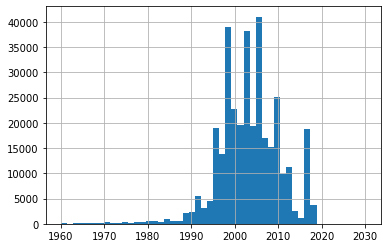

In [26]:
data['RegistrationYear'].hist(bins=50, range=(1960, 2030))

Судя по гистограмме, основная масса продаваемых автомобилей произведена в 1990-2019 гг. Немного расширим этот диапазон за счет 1980-х, остальные значения удалим.

In [27]:
data = data.query('RegistrationYear > 1985 & RegistrationYear < 2017')

In [28]:
data['RegistrationYear'].sort_values().unique()

array([1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996,
       1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007,
       2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016])

### Тип коробки передач

В этом столбце также много пропусков. Если их удалить, то потеряем большое количество данных. Поэтому заменим на 'unknown'.

In [29]:
data['Gearbox'].isna().sum()

13753

In [30]:
data['Gearbox'].sort_values().unique()

array(['auto', 'manual', nan], dtype=object)

In [31]:
data['Gearbox'].value_counts()

manual    246454
auto       61657
Name: Gearbox, dtype: int64

In [32]:
data['Gearbox'] = data['Gearbox'].fillna('unknown')

### Мощность (л.с.)

Пропусков нет, но есть другие проблемы. Есть как нулевые, так и очень высокие значения.

In [33]:
data['Power'].isna().sum()

0

In [34]:
data['Power'].describe()

count    321864.000000
mean        112.885045
std         184.382251
min           0.000000
25%          74.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

<AxesSubplot:>

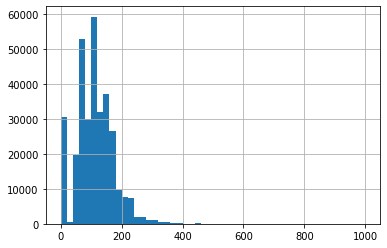

In [35]:
data['Power'].hist(bins=50, range=(0, 1000))

До мощности 400 лс продается заментное количество автомобилей. Можно поверить, что в таблице есть такие лоты. Все что дальше, похоже на ошибки и выбросы. Попробуем разделить слишком высокие значения на 100. Таким образом, максимальным значением в таблице у нас останется 400. Остальные приобретут более реальные значения.

In [36]:
data.loc[data['Power'] > 400, 'Power'] = data['Power'] / 100

In [37]:
data['Power'].describe()

count    321864.000000
mean        108.998868
std          61.129260
min           0.000000
25%          73.000000
50%         105.000000
75%         143.000000
max         400.000000
Name: Power, dtype: float64

<AxesSubplot:>

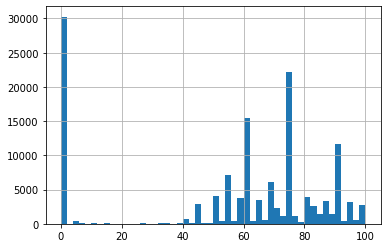

In [38]:
data['Power'].hist(bins=50, range=(0, 100))

Теперь разберемся с минимальными значениями. Здесь есть смысл оставить диапазон с 40 лс. Так как у нас очень много нулевых значений, и их удаление повлияет на качество обучения, то заменим все значения ниже 40 средним.

In [39]:
data.loc[data['Power'] < 40, 'Power'] = data['Power'].mean()

In [40]:
data['Power'].describe()

count    321864.000000
mean        119.623234
std          49.714808
min          40.000000
25%          85.000000
50%         108.998868
75%         143.000000
max         400.000000
Name: Power, dtype: float64

### Модель автомобиля

Пропуски в модели автомобиля заменим на пустую строку.

In [41]:
data['Model'].isna().sum()

14123

In [42]:
data['Model'].sort_values().unique()

array(['100', '145', '147', '156', '159', '1_reihe', '1er', '200',
       '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe',
       '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900',
       '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8',
       'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea',
       'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo',
       'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora',
       'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse',
       'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma',
       'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee',
       'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo',
       'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma',
       'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery',
       'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos',
       'escort', 'espac

In [43]:
data['Model'] = data['Model'].fillna('')

### Пробег (км)

В пробеге пропусков нет. Сами значения пока не трогаем.

In [44]:
data['Kilometer'].isna().sum()

0

In [45]:
data['Kilometer'].describe()

count    321864.000000
mean     128885.383267
std       36739.060889
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64

<AxesSubplot:>

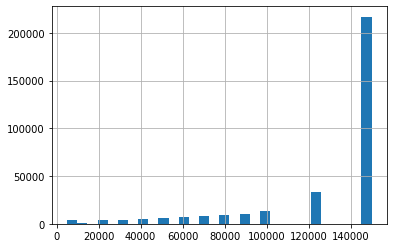

In [46]:
data['Kilometer'].hist(bins=30)

In [47]:
data['Kilometer'].value_counts()

150000    216984
125000     33785
100000     13351
90000      10731
80000       9275
70000       7987
60000       6975
50000       5764
40000       4599
30000       4039
5000        3932
20000       3495
10000        947
Name: Kilometer, dtype: int64

### Месяц регистрации автомобиля

Пропусков нет. Помимо того, что есть нулевой месяц, других странностей нет. Пока не трогаем этот столбец.

In [48]:
data['RegistrationMonth'].isna().sum()

0

In [49]:
data['RegistrationMonth'].sort_values().unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

<AxesSubplot:>

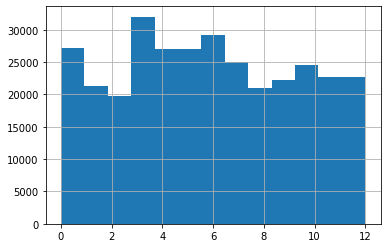

In [50]:
data['RegistrationMonth'].hist(bins=13)

### Тип топлива

Заменим пропуски на 'other', который уже присутствует в таблице.

In [51]:
data['FuelType'].isna().sum()

22190

In [52]:
data['FuelType'].sort_values().unique()

array(['cng', 'electric', 'gasoline', 'hybrid', 'lpg', 'other', 'petrol',
       nan], dtype=object)

In [53]:
data['FuelType'].value_counts()

petrol      199538
gasoline     94221
lpg           4971
cng            526
hybrid         219
other          114
electric        85
Name: FuelType, dtype: int64

In [54]:
data['FuelType'] = data['FuelType'].fillna('other')

### Марка автомобиля

Здесь все ок, оставим как есть.

In [55]:
data['Brand'].isna().sum()

0

In [56]:
data['Brand'].sort_values().unique()

array(['alfa_romeo', 'audi', 'bmw', 'chevrolet', 'chrysler', 'citroen',
       'dacia', 'daewoo', 'daihatsu', 'fiat', 'ford', 'honda', 'hyundai',
       'jaguar', 'jeep', 'kia', 'lada', 'lancia', 'land_rover', 'mazda',
       'mercedes_benz', 'mini', 'mitsubishi', 'nissan', 'opel', 'peugeot',
       'porsche', 'renault', 'rover', 'saab', 'seat', 'skoda', 'smart',
       'sonstige_autos', 'subaru', 'suzuki', 'toyota', 'trabant',
       'volkswagen', 'volvo'], dtype=object)

### Была ли машина в ремонте

Заменим пропуски на 'unknown'.

In [57]:
data['Repaired'].isna().sum()

56812

In [58]:
data['Repaired'].sort_values().unique()

array(['no', 'yes', nan], dtype=object)

In [59]:
data['Repaired'] = data['Repaired'].fillna('unknown')

In [60]:
data['Repaired'].value_counts()

no         233139
unknown     56812
yes         31913
Name: Repaired, dtype: int64

### Дата создания анкеты

Без изменений.

In [61]:
data['DateCreated'].isna().sum()

0

In [62]:
data['DateCreated']

0         2016-03-24 00:00:00
1         2016-03-24 00:00:00
2         2016-03-14 00:00:00
3         2016-03-17 00:00:00
4         2016-03-31 00:00:00
                 ...         
354363    2016-03-27 00:00:00
354365    2016-03-14 00:00:00
354366    2016-03-05 00:00:00
354367    2016-03-19 00:00:00
354368    2016-03-20 00:00:00
Name: DateCreated, Length: 321864, dtype: object

### Количество фотографий автомобиля

В столбце единственное значение - 0.

In [63]:
data['NumberOfPictures'].isna().sum()

0

In [64]:
data['NumberOfPictures'].unique()

array([0])

### Почтовый индекс владельца анкеты

In [65]:
data['PostalCode'].isna().sum()

0

In [66]:
data['PostalCode']

0         70435
1         66954
2         90480
3         91074
4         60437
          ...  
354363    26624
354365    39576
354366    26135
354367    87439
354368    40764
Name: PostalCode, Length: 321864, dtype: int64

### Дата последней активности пользователя

Без изменений.

In [67]:
data['LastSeen'].isna().sum()

0

In [68]:
data['LastSeen']

0         2016-04-07 03:16:57
1         2016-04-07 01:46:50
2         2016-04-05 12:47:46
3         2016-03-17 17:40:17
4         2016-04-06 10:17:21
                 ...         
354363    2016-03-29 10:17:23
354365    2016-04-06 00:46:52
354366    2016-03-11 18:17:12
354367    2016-04-07 07:15:26
354368    2016-03-24 12:45:21
Name: LastSeen, Length: 321864, dtype: object

### Итог

По итогам обработки данных, мы удалили все пропуски и аномальные значения, заменили их на другие значения, где это было возможно. Сбросим индекс и перейдем к следующему этапу.

In [69]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 321864 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   DateCrawled        321864 non-null  int64  
 1   Price              321864 non-null  int64  
 2   VehicleType        321864 non-null  object 
 3   RegistrationYear   321864 non-null  int64  
 4   Gearbox            321864 non-null  object 
 5   Power              321864 non-null  float64
 6   Model              321864 non-null  object 
 7   Kilometer          321864 non-null  int64  
 8   RegistrationMonth  321864 non-null  int64  
 9   FuelType           321864 non-null  object 
 10  Brand              321864 non-null  object 
 11  Repaired           321864 non-null  object 
 12  DateCreated        321864 non-null  object 
 13  NumberOfPictures   321864 non-null  int64  
 14  PostalCode         321864 non-null  int64  
 15  LastSeen           321864 non-null  object 
dtypes:

In [70]:
data.isna().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

In [71]:
data.duplicated().sum()

83

In [72]:
data = data.drop_duplicates()

In [73]:
data = data.reset_index(drop=True)

In [74]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016,480,other,1993,manual,108.998868,golf,150000,0,petrol,volkswagen,unknown,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016,18300,coupe,2011,manual,190.000000,,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016,9800,suv,2004,auto,163.000000,grand,125000,8,gasoline,jeep,unknown,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016,1500,small,2001,manual,75.000000,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016,3600,small,2008,manual,69.000000,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


## Создание новых признаков

Из нашего датасета можно сделать новые признаки, которые будут полезны при обучении моделей.

В первую очередь извлечем год из столбца с датой регистрации автомобиля. После этого вычтем из него год производства и получим возраст продаваемого авто.

In [75]:
data['DateCreated'] = pd.to_datetime(data['DateCreated'], format='%Y-%m-%d %H:%M')
data['DateCreated'] = data['DateCreated'].dt.year
data['DateCreated']

0         2016
1         2016
2         2016
3         2016
4         2016
          ... 
321776    2016
321777    2016
321778    2016
321779    2016
321780    2016
Name: DateCreated, Length: 321781, dtype: int64

In [76]:
data['Age'] = data['DateCreated'] - data['RegistrationYear']

Также соединим бренд и модель автомобиля.

In [77]:
data['Brand'] = data['Brand'] + ' ' + data['Model']

In [78]:
data.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen',
       'Age'],
      dtype='object')

Оставим только те признаки, которые будут полезны нам при обучении.

In [79]:
data = data[['Brand', 'VehicleType', 'Gearbox', 'Power', 'Kilometer', 'FuelType', 
             'Repaired', 'RegistrationYear', 'Age', 'Price']]

In [80]:
data

,Brand,VehicleType,Gearbox,Power,Kilometer,FuelType,Repaired,RegistrationYear,Age,Price
0,volkswagen golf,other,manual,108.998868,150000,petrol,unknown,1993,23,480
1,audi,coupe,manual,190.000000,125000,gasoline,yes,2011,5,18300
2,jeep grand,suv,auto,163.000000,125000,gasoline,unknown,2004,12,9800
3,volkswagen golf,small,manual,75.000000,150000,petrol,no,2001,15,1500
4,skoda fabia,small,manual,69.000000,90000,gasoline,no,2008,8,3600
...,...,...,...,...,...,...,...,...,...,...
321776,opel zafira,bus,manual,108.998868,150000,petrol,no,2000,16,1150
321777,sonstige_autos,other,unknown,108.998868,20000,other,unknown,2005,11,2200
321778,smart fortwo,convertible,auto,101.000000,125000,petrol,no,2000,16,1199
321779,volkswagen transporter,bus,manual,102.000000,150000,gasoline,no,1996,20,9200


Проверим еще раз итоговую таблицу на дубликаты. Их получилось достаточно много. Возможно, кто-то загружал одну и ту же анкету несколько раз, или у этого есть другие причины, но дубликаты нам не нужны, их нужно удалить.

In [81]:
data.duplicated().sum()

41884

In [82]:
data = data.drop_duplicates()

In [83]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 279897 entries, 0 to 321780
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Brand             279897 non-null  object 
 1   VehicleType       279897 non-null  object 
 2   Gearbox           279897 non-null  object 
 3   Power             279897 non-null  float64
 4   Kilometer         279897 non-null  int64  
 5   FuelType          279897 non-null  object 
 6   Repaired          279897 non-null  object 
 7   RegistrationYear  279897 non-null  int64  
 8   Age               279897 non-null  int64  
 9   Price             279897 non-null  int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 23.5+ MB


In [84]:
data = data.reset_index(drop=True)

## Обучение моделей

Выделим целевой признак - цена автомобиля.

In [85]:
features = data.drop(['Price'], axis=1)
target = data['Price']

Так как у нас есть отдельной тестовой выборки, то разделим датасет на три части - обучающую, валидационную и тестовую.

In [86]:
features_train, features_valid, target_train, target_valid = train_test_split(features, target, 
                                                                              test_size=0.4, 
                                                                              random_state=12345)

In [87]:
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid, 
                                                                            test_size=0.5, random_state=12345)

In [88]:
print(features_train.shape)
print(target_train.shape)
print(features_valid.shape)
print(target_valid.shape)
print(features_test.shape)
print(target_test.shape)

(167938, 9)
(167938,)
(55979, 9)
(55979,)
(55980, 9)
(55980,)


In [89]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

In [90]:
features_train = encoder.fit_transform(features_train)
features_valid = encoder.transform(features_valid)
features_test = encoder.transform(features_test)

Далее приведем признаки к единому масштабу.

In [91]:
scaler = StandardScaler()

In [92]:
scaler.fit(features_train)

StandardScaler()

In [93]:
features_train = scaler.transform(features_train)
features_valid = scaler.transform(features_valid)
features_test = scaler.transform(features_test)

Первой рассмотрим модель дерева решений. На выбранных параметрах она показала результат 750.9.

In [94]:
%%time

dtr_model = None
dtr_result = 10000

for depth in range(1, 25):
    for leaf in range(1, 10):
        model = DecisionTreeRegressor(random_state=12345, max_depth=depth, min_samples_leaf=leaf)
        model.fit(features_train, target_train)
        predictions_valid = model.predict(features_valid)
        result = (mean_squared_error(target_valid, predictions_valid)) ** 0.5
    
        if result < dtr_result:
            dtr_model = model
            dtr_result = result

CPU times: user 1min 13s, sys: 57 ms, total: 1min 13s
Wall time: 1min 13s


In [95]:
dtr_result

1798.4613186790205

In [96]:
dtr_model

DecisionTreeRegressor(max_depth=20, min_samples_leaf=8, random_state=12345)

Модель случайного леса показала аналогичный результат 759.9.

In [103]:
%%time

rfr_model = None
rfr_result = 10000

for est in range(1, 15):
    for depth in range(1, 15):
        model = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_train, target_train)
        predictions_valid = model.predict(features_valid)
        result = (mean_squared_error(target_valid, predictions_valid)) ** 0.5
        
        if result < rfr_result:
            rfr_model = model
            rfr_result = result

CPU times: user 4min 14s, sys: 260 ms, total: 4min 14s
Wall time: 4min 14s


In [104]:
rfr_result

1691.526809525671

In [106]:
rfr_model

RandomForestRegressor(max_depth=14, n_estimators=14, random_state=12345)

Модель LightGBM показала лучший результат без использования дополнительных параметров.

In [107]:
%%time

lgbm_model = LGBMRegressor(random_state=12345)
lgbm_model.fit(features_train, target_train)
lgbm_predictions_valid = lgbm_model.predict(features_valid)
lgbm_result = (mean_squared_error(target_valid, lgbm_predictions_valid)) ** 0.5
lgbm_result

CPU times: user 4.29 s, sys: 56.7 ms, total: 4.35 s
Wall time: 4.3 s


1663.3987886838856

In [108]:
%%time
lgbm_result_1 = 10000
lgbm_model_1 = None

for est in range(1, 10):
    for depth in range(1, 10):
        model = LGBMRegressor(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_train, target_train)
        predictions_valid = model.predict(features_valid)
        result = (mean_squared_error(target_valid, predictions_valid)) ** 0.5
        
        if result < lgbm_result_1:
            lgbm_result_1 = result
            lgbm_model_1 = model

CPU times: user 1min 7s, sys: 194 ms, total: 1min 8s
Wall time: 1min 8s


In [109]:
lgbm_result_1

2719.259434613154

In [110]:
lgbm_model_1

LGBMRegressor(max_depth=7, n_estimators=9, random_state=12345)

## Анализ моделей

Возьмем лучшую из полученных моделей и проверим ее на тестовой выборке. Результат получился похожим на полученный на валидационной выборке. На обучение было потрачено около 6 мин.

In [111]:
%%time

predictions_test = lgbm_model.predict(features_test)
result = (mean_squared_error(target_test, predictions_test)) ** 0.5
result

CPU times: user 417 ms, sys: 7.63 ms, total: 425 ms
Wall time: 406 ms


1662.4407181326644

## Вывод

В ходе работы мы провели исследование данных: убрали дубликаты, пропуски, заменили пропущенные значения, где это возможно. На основе полученных данных были созданы два новых признака. 

По условию задачи необходимо было использовать несколько разных моделей. Мы начали с более простых - решающего дерева и случайного леса. На них были получены похожие результаты rmse - 757. Также мы обучили модель LightGBM. На простой модели без дополнительных параметров был получен результат около 350. Такое же значение получилось на тестовой выборке. На обучение модели требуется около 6 мин.